In [2]:
import tensorflow as tf
import keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.models import Sequential
from keras.models import model_from_json
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint 
from keras.optimizers import Adam
from keras.utils import np_utils
import glob         
import sys
import numpy as np 
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore") 
import mymodule
from mymodule import BatchGenerator
from mymodule import Make_Raw_List2
from mymodule import plot_loss_accuracy_graph
import shutil
import os

In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
#build the resnet model
model = ResNet50(include_top=False, input_shape=(256, 256, 3))
flat1 = Flatten()(model.output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(2, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [39]:
#initiate the image data generator, and rescale the iamge 
idg = ImageDataGenerator(rescale=1./255)

In [6]:
#label the normal and abnormal fundus in the dataframe
#1: healthy, 0:abnormal
def health(x):
    if x!=0:
        a=0
    else:
        a=1
    return a

def unhealth(x):
    if x!=0:
        a=1
    else:
        a=0
    return a

In [7]:
#get the path
root=os.getcwd()
root

'/Users/ziyingye/Desktop/stats/stats402/data/Fundus_Diagnosis-master'

In [8]:
import pandas as pd
df=pd.read_csv(csv_filename)
df['HE_on']=df['AMD']+df['RVO']+df['Gla']+df['MH']+df['DR']+df['RD']+df['RP']+df['AO']+df['DM']
df['HE']=df['HE_on'].apply(lambda x: health(x))
# df['unHE']=df['HE_on'].apply(lambda x: unhealth(x))
df

,filename,ID,age,sex,LR,AMD,RVO,Gla,MH,DR,RD,RP,AO,DM,HE_on,HE
0,000000_00.jpg,3090,78,M,L,0,0,0,0,0,0,0,0,0,0,1
1,000000_01.jpg,3090,78,M,R,0,0,0,0,0,0,0,0,0,0,1
2,000001_00.jpg,2702,76,F,L,0,0,0,0,0,0,0,0,0,0,1
3,000001_01.jpg,2702,76,F,R,0,0,0,0,0,0,0,0,0,0,1
4,000001_02.jpg,1136,69,M,L,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13042,005387_01.jpg,3657,73,F,L,0,0,0,0,0,0,0,0,0,0,1
13043,005387_02.jpg,173,73,F,R,0,0,0,0,0,0,0,0,0,0,1
13044,005387_03.jpg,3156,71,F,R,0,0,0,0,0,0,0,0,0,0,1
13045,005388_00.jpg,3156,71,F,L,0,0,0,0,0,0,0,0,0,0,1


In [12]:
#all class name
class_name=['AMD','RVO','Gla','MH','DR','RD','RP','AO','DM','HE']
#diseases not included in the 3 class classification
od=['AMD', 'RVO', 'MH', 'RD', 'RP', 'AO', 'DM']
#disease and corresponding column index
od_d={'AMD': 5, 'RVO': 6, 'MH': 8, 'RD': 10, 'RP': 11, 'AO': 12, 'DM': 13}
#diseases included in the 3 class classification
nod=['Gla', 'DR', 'HE']

In [53]:
# help to produce the name of the model generated during cross-validation
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [73]:
#each separate diseases (not included in the 3 class classification)
# resnet
#5-fold cross validation
kf = KFold(n_splits = 5)  
# store the accuracy result
TRAINING_ACCURACY={}
VALIDATION_ACCURACY = {}
TEST_ACCURACY = {}
# the part of dataset with healthy fundus image
df_he=df.loc[df['HE']==1]
#set the directory
image_dir = root+'/img'
save_dir = root+'/cv_model/'
#for each separate diseases (AMD, RVO, MH, RD, RP, AO, DM)
# get same amount of random healthy images to perform classification
for p in od:
    df_t_d=df.loc[df[p]==1]
    df_t_he=df_he.sample(len(df_t_d))
    df_t=pd.concat([df_t_d,df_t_he])
    #make the label
    df_t['label']=0
    for i in range(len(df_t)):
        if df_t.iloc[i,od_d[p]]==1:
            df_t.iloc[i, -1]=str(p)
        else:
            df_t.iloc[i, -1]='HE'
    df_t=df_t[['filename','label']]
    df_t=df_t.loc[df_t['label']!=0]
    #shuffle the dataset
    df_t=df_t.sample(frac=1)
    #train-test split, training will be split into training and validation later
    df_t_train=df_t.iloc[:int(len(df_t)*0.8),]
    df_t_test=df_t.iloc[int(len(df_t)*0.8):,]
    #get the test data
    test_data_generator = idg.flow_from_dataframe(df_t_test, directory = image_dir,
                        x_col = "filename", y_col = "label",
                        class_mode = "categorical", shuffle = True)
    cv_fold=1
    # 5-fold cross validation
    for train_index, val_index in kf.split(df_t_train):
        df_t_train_train=df_t_train.iloc[train_index, :]
        df_t_train_val=df_t_train.iloc[val_index, :]
        #get training data
        train_data_generator = idg.flow_from_dataframe(df_t_train_train, directory = image_dir,
                                x_col = "filename", y_col = "label",
                                class_mode = "categorical", shuffle = True)
        #get validation data
        train_val_data_generator = idg.flow_from_dataframe(df_t_train_val, directory = image_dir,
                            x_col = "filename", y_col = "label",
                            class_mode = "categorical", shuffle = True)
        #compile the model
        model.compile(loss = 'categorical_crossentropy', optimizer = "sgd", metrics = ["accuracy"])
        #create callbacks
        checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(p), 
                                monitor='val_accuracy', verbose=1, 
                                save_best_only=True, mode='max')
        callbacks_list = [checkpoint]
        #train the model
        history = model.fit(train_data_generator,epochs=5,callbacks=callbacks_list,validation_data=train_val_data_generator)
        TRAINING_ACCURACY[str(p)+str(cv_fold)]=history.history['accuracy']
        VALIDATION_ACCURACY[str(p)+str(cv_fold)]=history.history['val_accuracy']
        #save the model
        model.save(save_dir+'/model_'+str(p)+str(cv_fold)+'.h5')
        cv_fold+=1
    print(str(p)+'CV_finished')
    #load the model with highest validation accuracy to evaluate the performance 
    l_t=[str(p)+str(k) for k in range(1,6)]
    val_acc_p={x: VALIDATION_ACCURACY[x] for x in l_t}
    model_max_val_acc_p=max(val_acc_p, key=val_acc_p.get)
    model.load_weights(save_dir+"/model_"+str(model_max_val_acc_p)+".h5")
    results = model.evaluate(test_data_generator)
    results = dict(zip(model.metrics_names,results))
    TEST_ACCURACY[str(p)]=results['accuracy']
    print(str(p)+'test_finished')
    tf.keras.backend.clear_session()
    

Found 166 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.
Epoch 1/5
17/17 [==============================] - ETA: 0s - loss: 0.5629 - accuracy: 0.7216
Epoch 1: val_accuracy improved from -inf to 0.53788, saving model to /Users/ziyingye/Desktop/stats/stats402/data/Fundus_Diagnosis-master/cv_model/model_AMD.h5
17/17 [==============================] - 159s 9s/step - loss: 0.5629 - accuracy: 0.7216 - val_loss: 0.8486 - val_accuracy: 0.5379
Epoch 2/5
17/17 [==============================] - ETA: 0s - loss: 0.2088 - accuracy: 0.9299
Epoch 2: val_accuracy improved from 0.53788 to 0.71212, saving model to /Users/ziyingye/Desktop/stats/stats402/data/Fundus_Diagnosis-master/cv_model/model_AMD.h5
17/17 [==============================] - 155s 9s/step - loss: 0.2088 - accuracy: 0.9299 - val_loss: 0.5548 - val_accuracy: 0.7121
Epoch 3/5
17/17 [==============================] - ET

In [76]:
TRAINING_ACCURACY

{'AMD1': [0.7215909361839294, 0.9299242496490479, 1.0, 1.0, 1.0],
 'AMD2': [0.9185606241226196, 0.9962121248245239, 1.0, 1.0, 1.0],
 'AMD3': [1.0, 1.0, 1.0, 1.0, 1.0],
 'AMD4': [1.0, 1.0, 1.0, 1.0, 1.0],
 'AMD5': [1.0, 1.0, 1.0, 1.0, 1.0],
 'RVO1': [0.7185929417610168,
  0.8864321708679199,
  0.9718592762947083,
  0.9969848990440369,
  0.9396985173225403],
 'RVO2': [0.9567838907241821,
  0.9989949464797974,
  1.0,
  1.0,
  0.9477387070655823],
 'RVO3': [0.9778894186019897, 0.9989949464797974, 1.0, 1.0, 1.0],
 'RVO4': [0.9979899525642395, 1.0, 0.9989949464797974, 1.0, 1.0],
 'RVO5': [1.0, 1.0, 1.0, 1.0, 1.0],
 'MH1': [0.7112675905227661, 0.9647887349128723, 1.0, 1.0, 1.0],
 'MH2': [0.9507042169570923, 1.0, 1.0, 1.0, 1.0],
 'MH3': [1.0, 1.0, 1.0, 1.0, 1.0],
 'MH4': [1.0, 1.0, 1.0, 1.0, 1.0],
 'MH5': [1.0, 1.0, 1.0, 1.0, 1.0],
 'RD1': [0.8764045238494873, 0.983146071434021, 1.0, 1.0, 1.0],
 'RD2': [0.983146071434021, 0.9983948469161987, 1.0, 1.0, 1.0],
 'RD3': [0.9983948469161987, 1.0, 1.

In [77]:
VALIDATION_ACCURACY

{'AMD1': [0.5378788113594055,
  0.7121211886405945,
  0.7348484992980957,
  0.7651515007019043,
  0.7424242496490479],
 'AMD2': [0.8409090638160706,
  0.8636363744735718,
  0.8787878751754761,
  0.9469696879386902,
  0.9545454382896423],
 'AMD3': [1.0, 1.0, 1.0, 1.0, 1.0],
 'AMD4': [1.0, 1.0, 1.0, 1.0, 1.0],
 'AMD5': [1.0, 1.0, 1.0, 1.0, 1.0],
 'RVO1': [0.8353413939476013,
  0.8674699068069458,
  0.8393574357032776,
  0.8795180916786194,
  0.8393574357032776],
 'RVO2': [0.8473895788192749,
  0.9678714871406555,
  0.9558233022689819,
  0.9477911591529846,
  0.8473895788192749],
 'RVO3': [0.9718875288963318,
  0.9879518151283264,
  0.9919678568840027,
  1.0,
  0.9919678568840027],
 'RVO4': [1.0, 1.0, 0.9759036302566528, 1.0, 1.0],
 'RVO5': [1.0, 1.0, 1.0, 1.0, 1.0],
 'MH1': [0.8028169274330139,
  0.8591549396514893,
  0.8873239159584045,
  0.8591549396514893,
  0.8591549396514893],
 'MH2': [0.8169013857841492,
  0.8450704216957092,
  0.8450704216957092,
  0.8732394576072693,
  0.91549295

In [74]:
TEST_ACCURACY

{'AMD': 0.7891566157341003,
 'RVO': 0.8205128312110901,
 'MH': 0.7865168452262878,
 'RD': 0.8820512890815735,
 'RP': 0.9615384340286255,
 'AO': 0.2222222238779068,
 'DM': 0.8851091265678406}

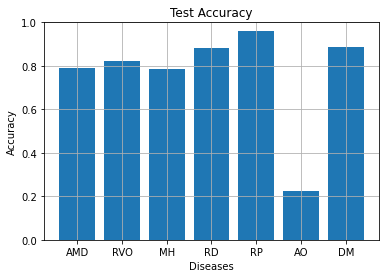

In [88]:
#plot the test accuracy for different diseases
fig1 = plt.gcf()
plt.grid()
plt.bar(list(TEST_ACCURACY.keys()),list(TEST_ACCURACY.values()))
# plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.title('Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Diseases')
# plt.legend(['train', 'validation'])
plt.show()

In [13]:
od_d

{'AMD': 5, 'RVO': 6, 'MH': 8, 'RD': 10, 'RP': 11, 'AO': 12, 'DM': 13}

In [15]:
df['ttt']=df['AMD']+df['RVO']+df['MH']+df['RD']+df['RP']+df['AO']+df['DM']
df_tt=df.loc[df['ttt']!=0]

,filename,ID,age,sex,LR,AMD,RVO,Gla,MH,DR,RD,RP,AO,DM,HE_on,HE,ttt
11,000004_00.jpg,3639,88,M,L,1,0,0,0,0,0,0,0,0,1,0,1
18,000006_01.jpg,4125,48,M,L,0,0,0,0,0,0,0,0,1,1,0,1
19,000007_00.jpg,4125,48,M,R,0,0,0,0,0,0,0,0,1,1,0,1
20,000007_01.jpg,4125,47,M,L,0,0,0,0,0,0,0,0,1,1,0,1
21,000007_02.jpg,4125,47,M,R,0,0,0,0,0,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13018,005379_00.jpg,2336,61,M,R,0,0,0,0,1,0,0,0,1,2,0,1
13019,005379_01.jpg,323,52,M,R,0,0,0,0,1,0,0,0,1,2,0,1
13020,005379_02.jpg,323,52,M,R,0,0,0,0,1,0,0,0,1,2,0,1
13021,005379_03.jpg,810,56,M,L,0,0,0,0,1,0,0,0,1,2,0,1


In [37]:
#get one sample image
df_sample=df_tt.sample()
df_sample['label']=0
for k in od_d.keys():
    if df_sample.loc[df_sample.index[0],k]!=0:
        df_sample.loc[df_sample.index[0],'label']=str(k)
df_sample

,filename,ID,age,sex,LR,AMD,RVO,Gla,MH,DR,RD,RP,AO,DM,HE_on,HE,ttt,label
2510,001051_00.jpg,5262,79,M,L,1,0,0,0,0,0,0,0,1,2,0,2,DM


In [43]:
image_dir = root+'/img'
save_dir = root+'/cv_model/'

In [42]:
#load the sample image as test data
test_data = idg.flow_from_dataframe(df_sample, directory = image_dir,
                    x_col = "filename", y_col = "label",
                    class_mode = "categorical", shuffle = True)

Found 1 validated image filenames belonging to 1 classes.


In [47]:
#load the test model
test_model = keras.models.load_model(save_dir+'/model_'+str(str(df_sample.loc[df_sample.index[0],'label']))+'.h5')

2022-12-14 01:38:31.317370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [49]:
#predict the sample 
df_p=pd.DataFrame(test_model.predict(test_data))
df_p

1/1 [==============================] - 0s 216ms/step


,0,1
0,1.0,4.250714e-10
